In [1]:
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import Dataset, Features, Value, load_dataset
import json
import os
import torch
import re
import html
import gc
import pandas as pd
import matplotlib.pyplot as plt

/home/thiagofernandes101/projects/fiap/FineTunningTechChallenge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
max_seq_length = 1024
dtype = None
load_in_4bit = True

In [3]:
def clean_text(text: str):
    # Your cleaning logic here
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r"--.*", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [4]:
def read_json_file(file_path: str):
    training_data = []

    with open(file_path, "r") as file:
        buffer: str = ""
        for line in file:
            buffer += line.strip()
            try:
                item: dict = json.loads(buffer)
                buffer: str = ""
                title: str = clean_text(item.get("title", ""))
                content: str = clean_text(item.get("content", ""))
                if title and content:
                    yield {"title": title, "content": content}
            except json.JSONDecodeError:
                continue
    return training_data

In [5]:
def format_for_training(example: dict, tokenizer) -> dict:
    title = example["title"]
    content = example["content"]

    # conversation = [
    #     {'role': 'user', 'content': f'Write a piece in the style of a book titled "{title}".'},
    #     {'role': 'assistant', 'content': content}
    # ]
    # formatted_text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
    formatted_text = f"### Title:\n{title}\n\n### Content:\n{content}"
    return {"text": formatted_text + tokenizer.eos_token}

In [6]:
fourbit_models = [
    #"unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    #"unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    #"unsloth/Phi-3-medium-4k-instruct",
    #"unsloth/gemma-2-9b-bnb-4bit"
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

==((====))==  Unsloth 2025.9.5: Fast Llama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.9.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [7]:
dataset_path = "/home/thiagofernandes101/projects/fiap/FineTunningTechChallenge/datasets/trn.json"

example_count = 0

with open(dataset_path, 'r') as file:
    for line in file:
        example_count += 1

print(f"Total examples found: {example_count:,}")

streaming_dataset = load_dataset("json", data_files=dataset_path, split="train", streaming=True)
filtered_dataset = streaming_dataset.filter(
    lambda example: example.get("title") and example.get("content")
)
processed_dataset = filtered_dataset.map(
    lambda example: format_for_training(example, tokenizer)
)

Total examples found: 2,248,619


In [8]:
training_args = TrainingArguments(
    output_dir="results",
    per_device_train_batch_size=2,  # Aumente se sua GPU permitir para acelerar
    gradient_accumulation_steps=4, # Ajuste para manter um lote efetivo de 8 (2*4)
    warmup_steps=5,
    max_steps = 1000, # Remova esta linha
    # num_train_epochs=1, # Adicione esta linha para treinar em todo o dataset uma vez
    learning_rate=2e-4,
    logging_steps=10,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = processed_dataset, # Convert to iterable dataset
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    args = training_args,
    packing = False, # Keep packing as it's efficient with streaming
)

In [9]:
def test_model(title_for_testing):
  # title_for_testing = "Jane's Battleships of the 20th Century"
  message_for_testing = [
      {"role": "user", "content": f'Tell me about the book "{title_for_testing}".'},
  ]
  input_ids = tokenizer.apply_chat_template(
      message_for_testing,
      tokenize=True,
      add_generation_prompt=True, # This is crucial for inference
      return_tensors="pt"
  ).to("cuda")
  outputs = model.generate(input_ids=input_ids, max_new_tokens=1024, use_cache=True)
  results = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
  print(results)

In [10]:
print("\n--- TEST (BEFORE) TRAINING ---")
test_model("Jane's Battleships of the 20th Century")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- TEST (BEFORE) TRAINING ---
Tell me about the book "Jane's Battleships of the 20th Century". "Jane's Battleships of the 20th Century" does not appear to be a widely recognized book or a well-known publication in the public domain as of my knowledge cutoff in 2023. It's possible that the book could be a niche or specialized publication, perhaps a work of historical interest or a fictional narrative.

If you are looking for information on a specific topic related to battleships or naval history, I can certainly help with that. However, for specific details about the book in question, I would need more context or information.

If you have more details or context about the book, please provide them, and I'll do my best to assist you. Given the lack of information about "Jane's Battleships of the 20th Century," I can't provide a detailed summary or analysis of the book. However, I can offer a general overview of the historical context of battleships in the 20th century, which might be r

In [11]:
print("Iniciando o fine-tuning...")
trainer_stats = trainer.train()
print("Fine-tuning concluído!")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 32009}.


Iniciando o fine-tuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,000 | Num Epochs = 9,223,372,036,854,775,807 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 29,884,416 of 3,850,963,968 (0.78% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.663500
20,2.464800
30,2.286800
40,2.241300
50,2.213900
60,2.232300
70,2.319800
80,2.208700
90,2.001700
100,2.096300


Fine-tuning concluído!


In [12]:
# --- Accessing the final stats ---
print("--- Overall Training Stats ---")
print(f"Total Steps Completed: {trainer_stats.global_step}")
print(f"Average Training Loss: {trainer_stats.training_loss:.4f}") # Format for readability

print("\n--- Detailed Log History ---")
# Access the detailed log from the trainer's state
log_history = trainer.state.log_history

for log in log_history:
    # We check if 'loss' is in the log, as the last entry might be the final training metrics
    if 'loss' in log:
        step = log['step']
        loss = log['loss']
        lr = log['learning_rate']
        print(f"Step: {step:<5} | Loss: {loss:.4f} | Learning Rate: {lr:.6f}")

--- Overall Training Stats ---
Total Steps Completed: 1000
Average Training Loss: 2.1148

--- Detailed Log History ---
Step: 10    | Loss: 2.6635 | Learning Rate: 0.000199
Step: 20    | Loss: 2.4648 | Learning Rate: 0.000197
Step: 30    | Loss: 2.2868 | Learning Rate: 0.000195
Step: 40    | Loss: 2.2413 | Learning Rate: 0.000193
Step: 50    | Loss: 2.2139 | Learning Rate: 0.000191
Step: 60    | Loss: 2.2323 | Learning Rate: 0.000189
Step: 70    | Loss: 2.3198 | Learning Rate: 0.000187
Step: 80    | Loss: 2.2087 | Learning Rate: 0.000185
Step: 90    | Loss: 2.0017 | Learning Rate: 0.000183
Step: 100   | Loss: 2.0963 | Learning Rate: 0.000181
Step: 110   | Loss: 2.0800 | Learning Rate: 0.000179
Step: 120   | Loss: 2.1133 | Learning Rate: 0.000177
Step: 130   | Loss: 2.1639 | Learning Rate: 0.000175
Step: 140   | Loss: 1.9684 | Learning Rate: 0.000173
Step: 150   | Loss: 2.0976 | Learning Rate: 0.000171
Step: 160   | Loss: 1.9691 | Learning Rate: 0.000169
Step: 170   | Loss: 1.9072 | Lear

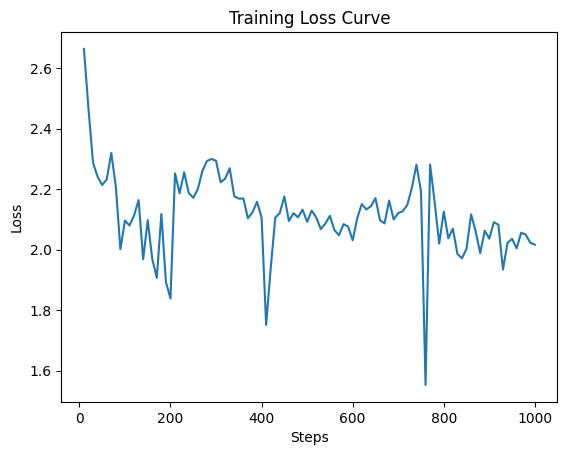

In [13]:
df = pd.DataFrame(log_history)
df.dropna(subset=['loss'], inplace=True) # Remove entries without a 'loss' key
plt.plot(df['step'], df['loss'])
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [14]:
print("\n--- TEST (AFTER) TRAINING ---")
test_model("Jane's Battleships of the 20th Century")


--- TEST (AFTER) TRAINING ---
Tell me about the book "Jane's Battleships of the 20th Century". "Jane's Battleships of the 20th Century" is a comprehensive guide to the development of naval warfare in the 20th century. The book, written by the renowned military analyst and author Jane's Information Group, provides detailed information on the design, construction, and operational history of battleships and other warships from the early 1900s to the end of the Cold War.

The book is divided into several sections, each focusing on a specific era or aspect of naval warfare. The first section, "The Early Years," covers the pre-World War I era, including the development of the dreadnought battleship and the naval arms race between Britain and Germany. The second section, "The World Wars," covers the role of battleships in both World War I and World War II, including the famous battles of Jutland and Midway.

The third section, "The Cold War," covers the development of nuclear-powered submari

In [15]:
print("\n--- TEST (AFTER) TRAINING ---")
test_model("Nice for Mice")


--- TEST (AFTER) TRAINING ---
Tell me about the book "Nice for Mice". "Nice for Mice" is a children's book written by the acclaimed author Judith Viorst. Published in 1982, the book is a humorous and engaging story that follows the adventures of a mouse named Mickey.

The story begins with Mickey, who is a very nice mouse, being invited to a party at the house of a very mean mouse named Sly. Mickey is excited about the party, but he is also a little nervous because he knows that Sly is not a very nice mouse.

As the story unfolds, Mickey discovers that Sly is not as mean as he appears. Sly is actually quite nice and has a lot of fun at the party. Mickey realizes that it's not always easy to judge someone based on their reputation, and that sometimes people can surprise you.

"Nice for Mice" is a delightful read for children, as it teaches valuable lessons about kindness, empathy, and not judging others. The book is filled with humor and charm, and it is sure to capture the imagination

In [16]:
print("\n--- TEST (AFTER) TRAINING ---")
test_model("Chromo Inc. 2x Pack 3.5mm Auxiliary Cable 1 Angled and 1 Flat Audio Music Aux - Orange")


--- TEST (AFTER) TRAINING ---
Tell me about the book "Chromo Inc. 2x Pack 3.5mm Auxiliary Cable 1 Angled and 1 Flat Audio Music Aux - Orange". "Chromo Inc. 2x Pack 3.5mm Auxiliary Cable 1 Angled and 1 Flat Audio Music Aux - Orange" appears to be a product listing for a pair of 3.5mm auxiliary cables, which are commonly used to connect audio devices to speakers or headphones. The description indicates that the cables come in two different styles: one with an angled connector and one with a flat connector. The color of the cables is orange.

These cables are likely intended for use with portable audio devices such as MP3 players, smartphones, or tablets. They are not books, but rather consumer electronics accessories. If you are looking for a book, please provide more specific information or a different query.
